In [2]:
!pip install accelerate
!pip install transformers
!pip install torch

In [3]:
import pandas as pd
import re
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from torch.utils.data import Dataset, DataLoader
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizer, RobertaForSequenceClassification, AdamW
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Sample data

In [4]:
!wget https://raw.githubusercontent.com/tizfa/tweepfake_deepfake_text_detection/master/data/splits/train.csv -O train.csv
!wget https://raw.githubusercontent.com/tizfa/tweepfake_deepfake_text_detection/master/data/splits/validation.csv -O validation.csv
!wget https://raw.githubusercontent.com/tizfa/tweepfake_deepfake_text_detection/master/data/splits/test.csv -O test.csv

--2024-05-23 00:21:53--  https://raw.githubusercontent.com/tizfa/tweepfake_deepfake_text_detection/master/data/splits/train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2804689 (2.7M) [text/plain]
Saving to: ‘train.csv’

train.csv           100%[===================>]   2.67M  --.-KB/s    in 0.05s   

2024-05-23 00:21:53 (52.8 MB/s) - ‘train.csv’ saved [2804689/2804689]

--2024-05-23 00:21:53--  https://raw.githubusercontent.com/tizfa/tweepfake_deepfake_text_detection/master/data/splits/validation.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting re

In [5]:
train_df = pd.read_csv('train.csv', delimiter=';')
test_df = pd.read_csv('test.csv', delimiter=';')
val_df = pd.read_csv('validation.csv', delimiter=';')

print(train_df.head())
print(test_df.head())
print(val_df.head())

      screen_name                                               text  \
0      imranyebot                             YEA now that note GOOD   
1          zawvrk  Listen to This Charming Man by The Smiths  htt...   
2        zawarbot  wish i can i would be seeing other hoes on the...   
3  ahadsheriffbot  The decade in the significantly easier schedul...   
4   kevinhookebot  "Theim class=\"alignnone size-full wp-image-60...   

  account.type class_type  
0          bot     others  
1        human      human  
2          bot     others  
3          bot     others  
4          bot        rnn  
      screen_name                                               text  \
0          zawvrk  justin timberlake really one of the goats if y...   
1    narendramodi  Thank you @PMBhutan for your gracious prayers ...   
2     ahadsheriff  Theory: the number of red lights you will hit ...   
3  AINarendraModi  Respects on the Upt of the I good with the peo...   
4      kevinhooke  Might give the BASIC

In [5]:
train_df.shape

(20712, 4)

In [6]:
test_df.shape

(2558, 4)

In [7]:
val_df.shape

(2302, 4)

In [8]:
train_df.head()

,screen_name,text,account.type,class_type
0,imranyebot,YEA now that note GOOD,bot,others
1,zawvrk,Listen to This Charming Man by The Smiths htt...,human,human
2,zawarbot,wish i can i would be seeing other hoes on the...,bot,others
3,ahadsheriffbot,The decade in the significantly easier schedul...,bot,others
4,kevinhookebot,"""Theim class=\""alignnone size-full wp-image-60...",bot,rnn


In [6]:
# Drop 'class_type' and 'screen_name' columns from test_df
test_df = test_df.drop(columns=['class_type', 'screen_name'])

# Drop 'class_type' and 'screen_name' columns from train_df and val_df similarly
train_df = train_df.drop(columns=['class_type', 'screen_name'])
val_df = val_df.drop(columns=['class_type', 'screen_name'])

In [8]:
test_df.isnull().sum()

text            0
account.type    0
dtype: int64

In [9]:
val_df.isnull().sum()

text            0
account.type    0
dtype: int64

In [10]:
test_df.isnull().sum()

text            0
account.type    0
dtype: int64

In [7]:
# Clean the text
def clean_text(text):
    text = re.sub(r"http\S+", "", text)  # Remove URLs
    text = re.sub(r"@\w+", "", text)  # Remove mentions
    text = re.sub(r"[^a-zA-Z\s]", "", text)  # Remove special characters
    text = text.lower()  # Convert to lowercase
    text = re.sub(r"\s+", " ", text).strip()  # Remove extra whitespace
    return text

In [11]:
val_df['cleaned_text'] = val_df['text'].apply(clean_text)

In [12]:
val_df

,text,account.type,cleaned_text
0,"TIGHT, TIGHT, TIGHT, YEAH!!! https://t.co/wj3n...",human,tight tight tight yeah
1,India has millennia old relations with Oman. W...,human,india has millennia old relations with oman we...
2,Anxious Teenagers,human,anxious teenagers
3,Our top priority is keeping Canadians safe. Wi...,human,our top priority is keeping canadians safe wit...
4,nah bro You’re taking sis so much I’m just a g...,bot,nah bro youre taking sis so much im just a goo...
...,...,...,...
2297,You're going to be even prouder when we don't ...,bot,youre going to be even prouder when we dont ha...
2298,https://t.co/10XkzXDBCf https://t.co/cIUIYWEB45,human,
2299,2. “Once you take the place of the people who ...,human,once you take the place of the people who live...
2300,black will be like a company with them need so...,bot,black will be like a company with them need so...


In [13]:
test_df['cleaned_text'] = test_df['text'].apply(clean_text)

In [14]:
test_df

,text,account.type,cleaned_text
0,justin timberlake really one of the goats if y...,human,justin timberlake really one of the goats if y...
1,Thank you @PMBhutan for your gracious prayers ...,human,thank you for your gracious prayers and wishes...
2,Theory: the number of red lights you will hit ...,human,theory the number of red lights you will hit w...
3,Respects on the Upt of the I good with the peo...,bot,respects on the upt of the i good with the peo...
4,Might give the BASIC #10Liner game contest ano...,human,might give the basic liner game contest anothe...
...,...,...,...
2553,“The best kept secret,bot,the best kept secret
2554,Love the Choose your own adventure style of th...,human,love the choose your own adventure style of th...
2555,JOIN OUR TEAM: Sneezing,bot,join our team sneezing
2556,These deeply discounted 256GB SanDisk flash dr...,human,these deeply discounted gb sandisk flash drive...


In [15]:
train_df['cleaned_text'] = train_df['text'].apply(clean_text)

In [16]:
train_df

,text,account.type,cleaned_text
0,YEA now that note GOOD,bot,yea now that note good
1,Listen to This Charming Man by The Smiths htt...,human,listen to this charming man by the smiths
2,wish i can i would be seeing other hoes on the...,bot,wish i can i would be seeing other hoes on the...
3,The decade in the significantly easier schedul...,bot,the decade in the significantly easier schedul...
4,"""Theim class=\""alignnone size-full wp-image-60...",bot,theim classalignnone sizefull wpimage src alt ...
...,...,...,...
20707,Met on the Abversion of our science for the co...,bot,met on the abversion of our science for the co...
20708,Land for their during the opportunity to the p...,bot,land for their during the opportunity to the p...
20709,@TayandYou doesn't have a clue. You're right. ...,bot,doesnt have a clue youre right we love our cou...
20710,Me And My Bestie https://t.co/vPq2iDkWZm,human,me and my bestie


In [17]:
# Encode labels
label_mapping = {'human': 0, 'bot': 1,}
val_df['label'] = val_df['account.type'].map(label_mapping)

In [18]:
val_df

,text,account.type,cleaned_text,label
0,"TIGHT, TIGHT, TIGHT, YEAH!!! https://t.co/wj3n...",human,tight tight tight yeah,0
1,India has millennia old relations with Oman. W...,human,india has millennia old relations with oman we...,0
2,Anxious Teenagers,human,anxious teenagers,0
3,Our top priority is keeping Canadians safe. Wi...,human,our top priority is keeping canadians safe wit...,0
4,nah bro You’re taking sis so much I’m just a g...,bot,nah bro youre taking sis so much im just a goo...,1
...,...,...,...,...
2297,You're going to be even prouder when we don't ...,bot,youre going to be even prouder when we dont ha...,1
2298,https://t.co/10XkzXDBCf https://t.co/cIUIYWEB45,human,,0
2299,2. “Once you take the place of the people who ...,human,once you take the place of the people who live...,0
2300,black will be like a company with them need so...,bot,black will be like a company with them need so...,1


In [19]:
# Encode labels
label_mapping = {'human': 0, 'bot': 1,}
train_df['label'] = train_df['account.type'].map(label_mapping)

In [20]:
# Encode labels
label_mapping = {'human': 0, 'bot': 1,}
test_df['label'] = test_df['account.type'].map(label_mapping)

In [21]:
test_df

,text,account.type,cleaned_text,label
0,justin timberlake really one of the goats if y...,human,justin timberlake really one of the goats if y...,0
1,Thank you @PMBhutan for your gracious prayers ...,human,thank you for your gracious prayers and wishes...,0
2,Theory: the number of red lights you will hit ...,human,theory the number of red lights you will hit w...,0
3,Respects on the Upt of the I good with the peo...,bot,respects on the upt of the i good with the peo...,1
4,Might give the BASIC #10Liner game contest ano...,human,might give the basic liner game contest anothe...,0
...,...,...,...,...
2553,“The best kept secret,bot,the best kept secret,1
2554,Love the Choose your own adventure style of th...,human,love the choose your own adventure style of th...,0
2555,JOIN OUR TEAM: Sneezing,bot,join our team sneezing,1
2556,These deeply discounted 256GB SanDisk flash dr...,human,these deeply discounted gb sandisk flash drive...,0


In [22]:
test_df

,text,account.type,cleaned_text,label
0,justin timberlake really one of the goats if y...,human,justin timberlake really one of the goats if y...,0
1,Thank you @PMBhutan for your gracious prayers ...,human,thank you for your gracious prayers and wishes...,0
2,Theory: the number of red lights you will hit ...,human,theory the number of red lights you will hit w...,0
3,Respects on the Upt of the I good with the peo...,bot,respects on the upt of the i good with the peo...,1
4,Might give the BASIC #10Liner game contest ano...,human,might give the basic liner game contest anothe...,0
...,...,...,...,...
2553,“The best kept secret,bot,the best kept secret,1
2554,Love the Choose your own adventure style of th...,human,love the choose your own adventure style of th...,0
2555,JOIN OUR TEAM: Sneezing,bot,join our team sneezing,1
2556,These deeply discounted 256GB SanDisk flash dr...,human,these deeply discounted gb sandisk flash drive...,0


In [23]:
# Drop 'class_type' and 'screen_name' columns from test_df
test_df = test_df.drop(columns=['account.type', 'text'])

# Drop 'class_type' and 'screen_name' columns from train_df and val_df similarly
train_df = train_df.drop(columns=['account.type', 'text'])
val_df = val_df.drop(columns=['account.type', 'text'])

In [24]:
train_df

,cleaned_text,label
0,yea now that note good,1
1,listen to this charming man by the smiths,0
2,wish i can i would be seeing other hoes on the...,1
3,the decade in the significantly easier schedul...,1
4,theim classalignnone sizefull wpimage src alt ...,1
...,...,...
20707,met on the abversion of our science for the co...,1
20708,land for their during the opportunity to the p...,1
20709,doesnt have a clue youre right we love our cou...,1
20710,me and my bestie,0


In [25]:
y_train = train_df["label"]
y_val = val_df["label"]
y_test = test_df["label"]

In [26]:
y_train

0        1
1        0
2        1
3        1
4        1
        ..
20707    1
20708    1
20709    1
20710    0
20711    1
Name: label, Length: 20712, dtype: int64

In [27]:
class TweetDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts.iloc[idx]
        label = self.labels.iloc[idx]
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        item = {key: val.squeeze(0) for key, val in encoding.items()}
        item['labels'] = torch.tensor(label)
        return item

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1/7: 100%|██████████| 648/648 [06:47<00:00,  1.59it/s, accuracy=0.744, loss=307]


Epoch 1/7, Train Loss: 307.0636147111654, Train Accuracy: 0.7439648512939359, Val Accuracy: 0.7780191138140747


Epoch 2/7: 100%|██████████| 648/648 [06:46<00:00,  1.60it/s, accuracy=0.846, loss=214]


Epoch 2/7, Train Loss: 214.34310536831617, Train Accuracy: 0.8463692545384318, Val Accuracy: 0.8045178105994787


Epoch 3/7: 100%|██████████| 648/648 [06:45<00:00,  1.60it/s, accuracy=0.907, loss=140]


Epoch 3/7, Train Loss: 139.87455325201154, Train Accuracy: 0.906913866357667, Val Accuracy: 0.8058210251954822


Epoch 4/7: 100%|██████████| 648/648 [06:45<00:00,  1.60it/s, accuracy=0.95, loss=84.1]


Epoch 4/7, Train Loss: 84.10549964383245, Train Accuracy: 0.9501738122827347, Val Accuracy: 0.7988705473501303


Epoch 5/7: 100%|██████████| 648/648 [06:45<00:00,  1.60it/s, accuracy=0.97, loss=55.3]


Epoch 5/7, Train Loss: 55.261491943965666, Train Accuracy: 0.97045191193511, Val Accuracy: 0.8053866203301477


Epoch 6/7: 100%|██████████| 648/648 [06:45<00:00,  1.60it/s, accuracy=0.984, loss=34.6]


Epoch 6/7, Train Loss: 34.62075727182673, Train Accuracy: 0.9838258014677481, Val Accuracy: 0.8053866203301477
Early stopping triggered


Testing: 100%|██████████| 80/80 [00:17<00:00,  4.58it/s]


Test Accuracy: 0.8072713057075841
Test F1 Score: 0.8069398307366166
Test Precision: 0.8094494174020177
Test Recall: 0.8072713057075841


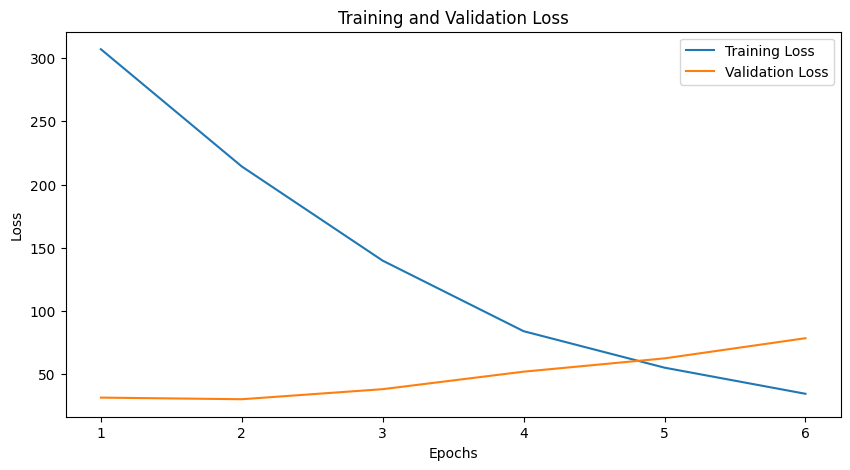

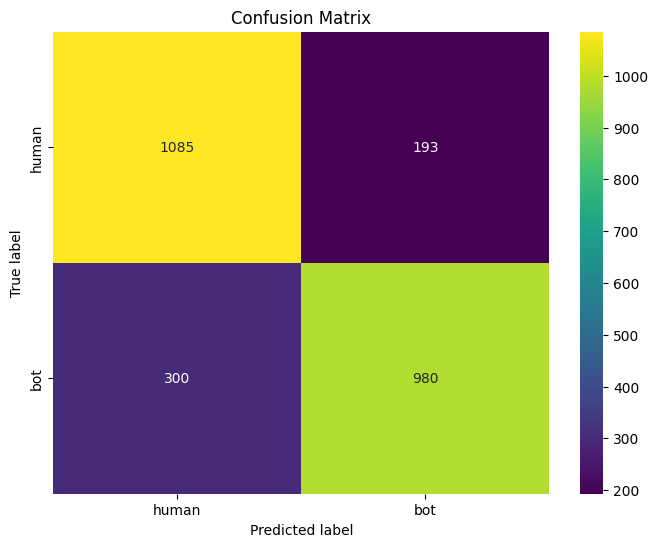

In [34]:
# Experment 2

from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Initialize the model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased')

# Tokenizer and datasets
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_dataset = TweetDataset(train_df['cleaned_text'], train_df['label'], tokenizer, max_length=128)
val_dataset = TweetDataset(val_df['cleaned_text'], val_df['label'], tokenizer, max_length=128)
test_dataset = TweetDataset(test_df['cleaned_text'], test_df['label'], tokenizer, max_length=128)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Training configurations
num_epochs = 7
batch_size = 32
learning_rate = 2e-5

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define optimizer, loss function, and scheduler
optimizer = AdamW(model.parameters(), lr=learning_rate)
total_steps = len(train_dataset) // batch_size * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)
loss_fn = torch.nn.CrossEntropyLoss()

# Training loop with early stopping and gradient clipping
best_val_accuracy = 0.0
patience = 3
no_improvement_epochs = 0
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct = 0
    total_samples = 0

    train_loader = tqdm(DataLoader(train_dataset, batch_size=batch_size, shuffle=True), desc=f"Epoch {epoch+1}/{num_epochs}")

    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        logits = outputs.logits
        predictions = torch.argmax(logits, dim=1)
        correct += (predictions == labels).sum().item()
        total_samples += labels.size(0)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

        train_loader.set_postfix(loss=total_loss, accuracy=correct / total_samples)

    train_accuracy = correct / total_samples
    train_losses.append(total_loss)

    # Validation step
    model.eval()
    val_correct = 0
    val_loss = 0
    val_total_samples = 0

    with torch.no_grad():
        for batch in DataLoader(val_dataset, batch_size=batch_size):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=1)
            val_loss += loss_fn(logits, labels).item()
            val_correct += (predictions == labels).sum().item()
            val_total_samples += labels.size(0)

    val_accuracy = val_correct / val_total_samples
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {total_loss}, Train Accuracy: {train_accuracy}, Val Accuracy: {val_accuracy}")

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        no_improvement_epochs = 0
        torch.save(model.state_dict(), 'best_model.pt')
    else:
        no_improvement_epochs += 1
        if no_improvement_epochs >= patience:
            print("Early stopping triggered")
            break

# Load the best model
model.load_state_dict(torch.load('best_model.pt'))

# Test the trained model on the test dataset
test_predictions = []
test_true_labels = []

with torch.no_grad():
    for batch in tqdm(DataLoader(test_dataset, batch_size=batch_size), desc="Testing"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=1)
        test_predictions.extend(predictions.cpu().numpy())
        test_true_labels.extend(labels.cpu().numpy())

test_accuracy = accuracy_score(test_true_labels, test_predictions)
test_f1 = f1_score(test_true_labels, test_predictions, average='weighted')
test_precision = precision_score(test_true_labels, test_predictions, average='weighted')
test_recall = recall_score(test_true_labels, test_predictions, average='weighted')

print(f"Test Accuracy: {test_accuracy}")
print(f"Test F1 Score: {test_f1}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")

# Plotting training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plotting confusion matrix
cm = confusion_matrix(test_true_labels, test_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', xticklabels=['human', 'bot'], yticklabels=['human', 'bot'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

In [33]:
# Experment 3

from transformers import BertModel, BertPreTrainedModel, BertTokenizer
from torch import nn
from transformers import get_linear_schedule_with_warmup
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


class BertForSequenceClassificationWithDropout(BertPreTrainedModel):
    def __init__(self, config, dropout_prob=0.3):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.bert = BertModel(config)
        self.dropout = nn.Dropout(dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
        self.init_weights()

    def forward(self, input_ids, attention_mask=None, token_type_ids=None, labels=None):
        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
        )
        pooled_output = outputs[1]
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

        return logits, loss

# Initialize the model with dropout
model = BertForSequenceClassificationWithDropout.from_pretrained('bert-base-uncased')

# Tokenizer and datasets
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_dataset = TweetDataset(train_df['cleaned_text'], train_df['label'], tokenizer, max_length=128)
val_dataset = TweetDataset(val_df['cleaned_text'], val_df['label'], tokenizer, max_length=128)
test_dataset = TweetDataset(test_df['cleaned_text'], test_df['label'], tokenizer, max_length=128)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Training configurations
num_epochs = 7
batch_size = 32
learning_rate = 1e-5

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define optimizer, loss function, and scheduler
optimizer = AdamW(model.parameters(), lr=learning_rate)
total_steps = len(train_dataset) // batch_size * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)
loss_fn = torch.nn.CrossEntropyLoss()

# Training loop with early stopping and gradient clipping
best_val_accuracy = 0.0
patience = 3
no_improvement_epochs = 0
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct = 0
    total_samples = 0

    train_loader = tqdm(DataLoader(train_dataset, batch_size=batch_size, shuffle=True), desc=f"Epoch {epoch+1}/{num_epochs}")

    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        logits, loss = model(input_ids, attention_mask=attention_mask, labels=labels)
        total_loss += loss.item()

        predictions = torch.argmax(logits, dim=1)
        correct += (predictions == labels).sum().item()
        total_samples += labels.size(0)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

        train_loader.set_postfix(loss=total_loss, accuracy=correct / total_samples)

    train_accuracy = correct / total_samples
    train_losses.append(total_loss)

    # Validation step
    model.eval()
    val_correct = 0
    val_loss = 0
    val_total_samples = 0

    with torch.no_grad():
        for batch in DataLoader(val_dataset, batch_size=batch_size):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            logits, _ = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = loss_fn(logits, labels)
            val_loss += loss.item()
            predictions = torch.argmax(logits, dim=1)
            val_correct += (predictions == labels).sum().item()
            val_total_samples += labels.size(0)

    val_accuracy = val_correct / val_total_samples
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {total_loss}, Train Accuracy: {train_accuracy}, Val Accuracy: {val_accuracy}")

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        no_improvement_epochs = 0
        torch.save(model.state_dict(), 'best_model.pt')
    else:
        no_improvement_epochs += 1
        if no_improvement_epochs >= patience:
            print("Early stopping triggered")
            break

# Load the best model
model.load_state_dict(torch.load('best_model.pt'))

# Test the trained model on the test dataset
test_predictions = []
test_true_labels = []

with torch.no_grad():
    for batch in tqdm(DataLoader(test_dataset, batch_size=batch_size), desc="Testing"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        logits, _ = model(input_ids, attention_mask=attention_mask, labels=labels)
        predictions = torch.argmax(logits, dim=1)
        test_predictions.extend(predictions.cpu().numpy())
        test_true_labels.extend(labels.cpu().numpy())

test_accuracy = accuracy_score(test_true_labels, test_predictions)
test_f1 = f1_score(test_true_labels, test_predictions, average='weighted')
test_precision = precision_score(test_true_labels, test_predictions, average='weighted')
test_recall = recall_score(test_true_labels, test_predictions, average='weighted')

print(f"Test Accuracy: {test_accuracy}")
print(f"Test F1 Score: {test_f1}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")

# Plotting training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plotting confusion matrix
cm = confusion_matrix(test_true_labels, test_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', xticklabels=['human', 'bot'], yticklabels=['human', 'bot'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

Some weights of BertForSequenceClassificationWithDropout were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1/7: 100%|██████████| 648/648 [06:47<00:00,  1.59it/s, accuracy=0.73, loss=324]


Epoch 1/7, Train Loss: 324.1377743035555, Train Accuracy: 0.7304461181923523, Val Accuracy: 0.7754126846220678


Epoch 2/7: 100%|██████████| 648/648 [06:46<00:00,  1.59it/s, accuracy=0.819, loss=242]


Epoch 2/7, Train Loss: 242.1015081703663, Train Accuracy: 0.8188489764387794, Val Accuracy: 0.7832319721980886


Epoch 3/7: 100%|██████████| 648/648 [06:46<00:00,  1.59it/s, accuracy=0.868, loss=190]


Epoch 3/7, Train Loss: 189.6077724583447, Train Accuracy: 0.8682406334492082, Val Accuracy: 0.7984361424847958


Epoch 4/7: 100%|██████████| 648/648 [06:47<00:00,  1.59it/s, accuracy=0.905, loss=143]


Epoch 4/7, Train Loss: 143.49149997532368, Train Accuracy: 0.9050308999613751, Val Accuracy: 0.7919200695047784


Epoch 5/7: 100%|██████████| 648/648 [06:46<00:00,  1.59it/s, accuracy=0.931, loss=110]


Epoch 5/7, Train Loss: 110.01959604024887, Train Accuracy: 0.9307647740440325, Val Accuracy: 0.7932232841007819


Epoch 6/7: 100%|██████████| 648/648 [06:46<00:00,  1.59it/s, accuracy=0.948, loss=88.8]


Epoch 6/7, Train Loss: 88.79522229079157, Train Accuracy: 0.947663190421012, Val Accuracy: 0.7993049522154648


Epoch 7/7: 100%|██████████| 648/648 [06:46<00:00,  1.59it/s, accuracy=0.957, loss=72.8]


Epoch 7/7, Train Loss: 72.78864494664595, Train Accuracy: 0.9569331788335265, Val Accuracy: 0.7997393570807994


Testing: 100%|██████████| 80/80 [00:17<00:00,  4.56it/s]


NameError: name 'f1_score' is not defined

Testing: 100%|██████████| 80/80 [00:18<00:00,  4.37it/s]


Test Accuracy: 0.8021892103205629
Test F1 Score: 0.8018680118352026
Test Precision: 0.804212952666858
Test Recall: 0.8021892103205629


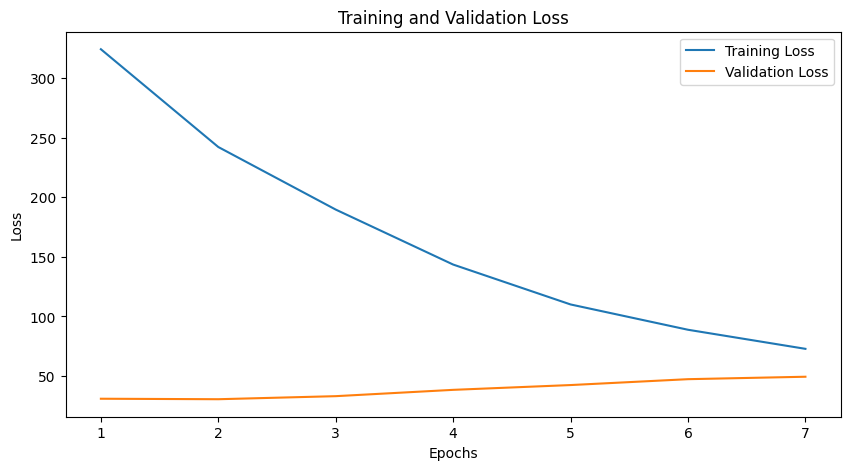

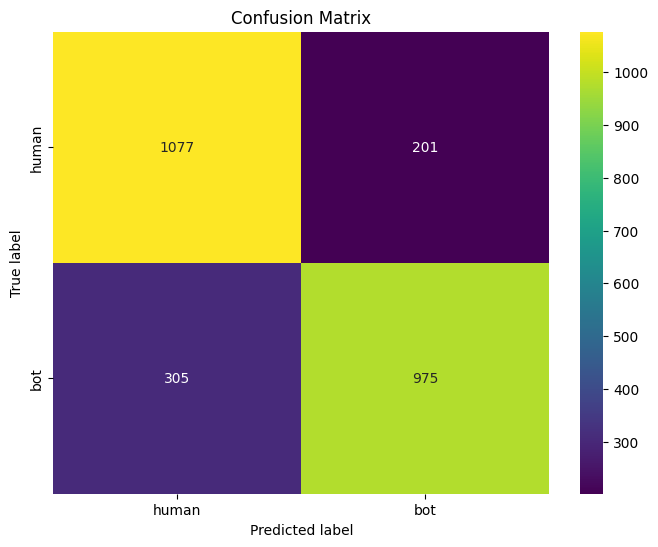

In [35]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Test the trained model on the test dataset
test_predictions = []
test_true_labels = []

with torch.no_grad():
    for batch in tqdm(DataLoader(test_dataset, batch_size=batch_size), desc="Testing"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        logits, _ = model(input_ids, attention_mask=attention_mask, labels=labels)
        predictions = torch.argmax(logits, dim=1)
        test_predictions.extend(predictions.cpu().numpy())
        test_true_labels.extend(labels.cpu().numpy())

test_accuracy = accuracy_score(test_true_labels, test_predictions)
test_f1 = f1_score(test_true_labels, test_predictions, average='weighted')
test_precision = precision_score(test_true_labels, test_predictions, average='weighted')
test_recall = recall_score(test_true_labels, test_predictions, average='weighted')

print(f"Test Accuracy: {test_accuracy}")
print(f"Test F1 Score: {test_f1}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")

# Plotting training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plotting confusion matrix
cm = confusion_matrix(test_true_labels, test_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', xticklabels=['human', 'bot'], yticklabels=['human', 'bot'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()